# Airfare Markets Under Pressure
## SDSS Datathon 2026 — Airline Ticket Data Analysis

**Data source:** `dataset/airline_ticket_data.csv`  
**Scope:** Domestic U.S. city-pair markets, Q1 2022 – Q2 2025  
**Key question:** What structural factors drive airfare prices, and who pays unfairly high prices?

---
## Phase 0: Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120

DATA_PATH = '../dataset/airline_ticket_data.csv'

In [2]:
# ── Load raw data ──────────────────────────────────────────────────────────────
df_raw = pd.read_csv(DATA_PATH)

# ── Clean numeric columns stored as strings ────────────────────────────────────
def clean_numeric(series):
    return (
        series.astype(str)
        .str.replace(r'[\$,]', '', regex=True)
        .str.strip()
        .replace('', np.nan)
        .astype(float)
    )

df = df_raw.copy()
df['passengers'] = clean_numeric(df['passengers'])
df['fare']       = clean_numeric(df['fare'])
df['fare_lg']    = clean_numeric(df['fare_lg'])
df['fare_low']   = clean_numeric(df['fare_low'])

print(f'Shape: {df.shape}')
print(f'Date range: Year {df.Year.min()} Q{df.quarter.min()} → Year {df.Year.max()} Q{df.quarter.max()}')
print(f'Null counts:\n{df.isnull().sum()[df.isnull().sum() > 0]}')

Shape: (14004, 21)
Date range: Year 2022 Q1 → Year 2025 Q4
Null counts:
TotalFaredPax_city1      7
TotalPerLFMkts_city1     7
TotalPerPrem_city1       7
TotalFaredPax_city2     25
TotalPerLFMkts_city2    25
TotalPerPrem_city2      25
dtype: int64


In [3]:
df.describe()

,Year,quarter,citymarketid_1,citymarketid_2,nsmiles,passengers,fare,large_ms,fare_lg,lf_ms,fare_low,TotalFaredPax_city1,TotalPerLFMkts_city1,TotalPerPrem_city1,TotalFaredPax_city2,TotalPerLFMkts_city2,TotalPerPrem_city2
count,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,1.399700e+04,13997.000000,13997.000000,1.397900e+04,13979.000000,13979.000000
mean,2023.285633,2.357112,31506.638889,32300.714296,1061.839617,1024.581762,237.699035,0.566322,245.713270,0.327737,180.954832,3.220308e+06,0.836383,-0.007360,2.955601e+06,0.832683,-0.038586
std,1.030128,1.108776,1214.185463,1421.194815,589.956663,1475.981346,63.929831,0.174240,77.518173,0.228027,69.241252,2.319576e+06,0.141082,0.108333,2.014224e+06,0.142587,0.119825
min,2022.000000,1.000000,30135.000000,30189.000000,129.000000,163.000000,76.770000,0.209700,76.770000,0.010000,66.160000,2.993000e+04,0.000000,-0.619400,5.464000e+04,0.000000,-0.641100
25%,2022.000000,1.000000,30529.000000,30852.000000,604.000000,316.000000,193.087500,0.431800,193.357500,0.154500,119.590000,1.224800e+06,0.793600,-0.051600,1.582850e+06,0.788400,-0.077500
50%,2023.000000,2.000000,31057.000000,32211.000000,936.000000,526.000000,227.640000,0.541600,239.245000,0.265550,175.215000,2.873210e+06,0.865900,-0.003200,2.764620e+06,0.863200,-0.022700
75%,2024.000000,3.000000,32244.000000,33342.000000,1404.000000,1086.250000,275.615000,0.676725,293.952500,0.444300,225.875000,4.254110e+06,0.922500,0.048400,3.661990e+06,0.939300,0.040500
max,2025.000000,4.000000,35412.000000,35628.000000,2724.000000,21058.000000,676.890000,1.000000,679.120000,1.000000,669.740000,8.840080e+06,1.000000,0.965900,8.840080e+06,1.000000,0.350800


In [4]:
# ── Derived columns used across all phases ─────────────────────────────────────

# Fare per mile (cost efficiency metric)
df['fare_per_mile'] = df['fare'] / df['nsmiles']

# Distance bands
df['distance_band'] = pd.cut(
    df['nsmiles'],
    bins=[0, 300, 800, 1500, np.inf],
    labels=['Short (<300)', 'Medium (300–800)', 'Long (800–1500)', 'Ultra (>1500)']
)

# Competition tier by dominant carrier share
df['competition_tier'] = pd.cut(
    df['large_ms'],
    bins=[0, 0.50, 0.80, 1.01],
    labels=['Competitive (<50%)', 'Dominant (50–80%)', 'Monopoly (>80%)']
)

# LCC presence flag
df['has_lcc'] = df['lf_ms'] > 0.05

# City size: Major vs Secondary based on passenger volume
fared_pax_all = pd.concat([
    df[['citymarketid_1', 'TotalFaredPax_city1']].rename(columns={'citymarketid_1': 'cid', 'TotalFaredPax_city1': 'pax'}),
    df[['citymarketid_2', 'TotalFaredPax_city2']].rename(columns={'citymarketid_2': 'cid', 'TotalFaredPax_city2': 'pax'})
])
pax_median = fared_pax_all['pax'].median()

df['city_size_1'] = np.where(df['TotalFaredPax_city1'] >= pax_median, 'Major', 'Secondary')
df['city_size_2'] = np.where(df['TotalFaredPax_city2'] >= pax_median, 'Major', 'Secondary')

# Route type
def route_type(row):
    if row['city_size_1'] == 'Major' and row['city_size_2'] == 'Major':
        return 'Hub–Hub'
    elif row['city_size_1'] == 'Secondary' and row['city_size_2'] == 'Secondary':
        return 'Secondary–Secondary'
    else:
        return 'Hub–Secondary'

df['route_type'] = df.apply(route_type, axis=1)

# Average city-level fare premium across both endpoints
df['hub_premium_avg'] = (df['TotalPerPrem_city1'] + df['TotalPerPrem_city2']) / 2

# Route label for display
df['route_label'] = df['city1'].str.extract(r'^([^,]+)') + ' ↔ ' + df['city2'].str.extract(r'^([^,]+)')

print('Derived columns added.')
print(f"Distance bands:\n{df['distance_band'].value_counts().sort_index()}")
print(f"\nCompetition tiers:\n{df['competition_tier'].value_counts().sort_index()}")
print(f"\nRoute types:\n{df['route_type'].value_counts()}")
print(f"\nHas LCC: {df['has_lcc'].value_counts().to_dict()}")

Derived columns added.
Distance bands:
distance_band
Short (<300)         599
Medium (300–800)    4812
Long (800–1500)     5569
Ultra (>1500)       3024
Name: count, dtype: int64

Competition tiers:
competition_tier
Competitive (<50%)    5663
Dominant (50–80%)     6673
Monopoly (>80%)       1668
Name: count, dtype: int64

Route types:
route_type
Hub–Secondary          8635
Secondary–Secondary    2687
Hub–Hub                2682
Name: count, dtype: int64

Has LCC: {True: 13394, False: 610}


---
## Phase 1: Equity & Overpricing Analysis

**Goal:** Identify which routes and cities pay more than their peers at comparable distance — without a predictive model, using fare-per-mile benchmarks and within-segment comparisons.

### 1.1 Overpriced Routes — Fare-Per-Mile Benchmark

In [5]:
# Benchmark: median fare_per_mile within each distance band
band_median_fpm = df.groupby('distance_band', observed=True)['fare_per_mile'].median().rename('band_median_fpm')
df_fpm = df.merge(band_median_fpm, on='distance_band')
df_fpm['fpm_ratio'] = df_fpm['fare_per_mile'] / df_fpm['band_median_fpm']

# Flag overpriced: fare_per_mile > 1.5× band median
df_overpriced = df_fpm[df_fpm['fpm_ratio'] > 1.5].copy()

top20_overpriced = (
    df_overpriced
    .groupby('route_label', observed=True)
    .agg(
        mean_fare       = ('fare', 'mean'),
        mean_fpm        = ('fare_per_mile', 'mean'),
        band_median_fpm = ('band_median_fpm', 'mean'),
        fpm_ratio       = ('fpm_ratio', 'mean'),
        competition     = ('competition_tier', lambda x: x.mode()[0]),
        distance_band   = ('distance_band', 'first'),
        nsmiles         = ('nsmiles', 'mean')
    )
    .sort_values('fpm_ratio', ascending=False)
    .head(20)
    .reset_index()
)

top20_overpriced[['route_label','distance_band','mean_fare','mean_fpm','band_median_fpm','fpm_ratio','competition']].round(2)

,route_label,distance_band,mean_fare,mean_fpm,band_median_fpm,fpm_ratio,competition
0,Charlotte ↔ Columbus,Medium (300–800),295.56,0.85,0.37,2.31,Monopoly (>80%)
1,Aspen ↔ New York City,Ultra (>1500),613.82,0.35,0.15,2.26,Dominant (50–80%)
2,Charlotte ↔ Jacksonville,Medium (300–800),274.20,0.84,0.37,2.26,Monopoly (>80%)
3,Atlanta ↔ Greensboro/High Point,Medium (300–800),247.72,0.81,0.37,2.19,Monopoly (>80%)
4,Eagle ↔ Miami,Ultra (>1500),590.09,0.33,0.15,2.10,Monopoly (>80%)
5,Charlotte ↔ Cincinnati,Medium (300–800),249.14,0.74,0.37,2.01,Monopoly (>80%)
6,Charlotte ↔ Pittsburgh,Medium (300–800),271.05,0.74,0.37,2.00,Monopoly (>80%)
7,Eagle ↔ New York City,Ultra (>1500),535.10,0.31,0.15,1.98,Dominant (50–80%)
8,Columbus ↔ Philadelphia,Medium (300–800),294.48,0.73,0.37,1.96,Monopoly (>80%)
9,Atlanta ↔ Louisville,Medium (300–800),232.40,0.72,0.37,1.96,Monopoly (>80%)


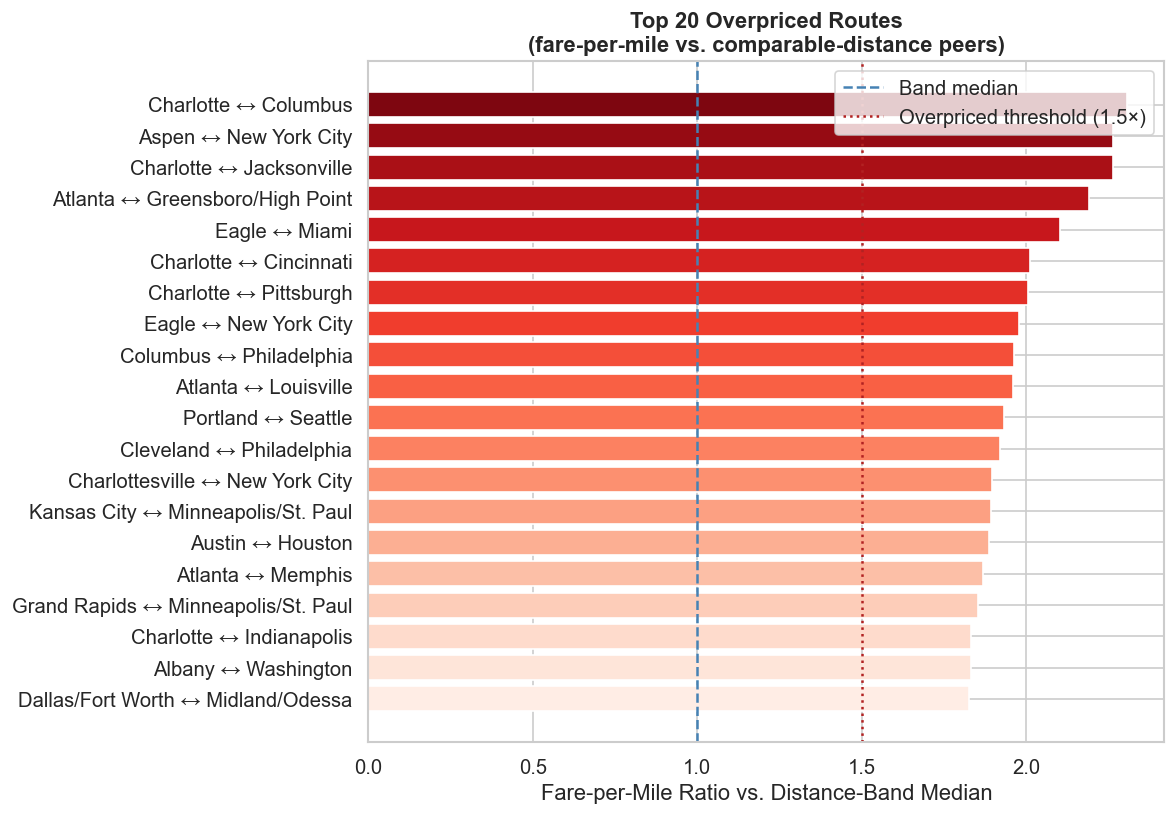

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
colors = sns.color_palette('Reds_r', n_colors=20)
bars = ax.barh(top20_overpriced['route_label'], top20_overpriced['fpm_ratio'], color=colors)
ax.axvline(1.0, color='steelblue', linestyle='--', linewidth=1.5, label='Band median')
ax.axvline(1.5, color='firebrick', linestyle=':', linewidth=1.5, label='Overpriced threshold (1.5×)')
ax.set_xlabel('Fare-per-Mile Ratio vs. Distance-Band Median')
ax.set_title('Top 20 Overpriced Routes\n(fare-per-mile vs. comparable-distance peers)', fontweight='bold')
ax.invert_yaxis()
ax.legend()
plt.tight_layout()
plt.show()

**Chart caption:** Routes are ranked by how much their fare-per-mile exceeds the median for flights of similar distance. A ratio of 2.0 means travelers pay twice the per-mile rate of comparable routes.

### 1.2 Secondary City Penalty

In [7]:
# Mean fare by route_type
route_fare = df.groupby('route_type')['fare'].agg(['mean','median','count']).round(2)
print('Mean fare by route type:')
print(route_fare)

hub_hub_mean = route_fare.loc['Hub–Hub','mean']
hub_sec_mean = route_fare.loc['Hub–Secondary','mean']
sec_sec_mean = route_fare.loc['Secondary–Secondary','mean']

print(f'\nHub–Secondary premium over Hub–Hub: ${hub_sec_mean - hub_hub_mean:.2f} ({(hub_sec_mean/hub_hub_mean - 1)*100:.1f}%)')
print(f'Secondary–Secondary premium over Hub–Hub: ${sec_sec_mean - hub_hub_mean:.2f} ({(sec_sec_mean/hub_hub_mean - 1)*100:.1f}%)')

Mean fare by route type:
                       mean  median  count
route_type                                
Hub–Hub              249.67  234.80   2682
Hub–Secondary        238.72  229.32   8635
Secondary–Secondary  222.48  212.61   2687

Hub–Secondary premium over Hub–Hub: $-10.95 (-4.4%)
Secondary–Secondary premium over Hub–Hub: $-27.19 (-10.9%)


In [8]:
# Controlled for distance band
secondary_penalty = (
    df.groupby(['distance_band', 'route_type'], observed=True)['fare']
    .mean()
    .unstack('route_type')
    .round(2)
)
print('Mean fare by distance band × route type:')
print(secondary_penalty)

Mean fare by distance band × route type:
route_type        Hub–Hub  Hub–Secondary  Secondary–Secondary
distance_band                                                
Short (<300)       188.19         193.68               180.11
Medium (300–800)   192.93         210.56               191.92
Long (800–1500)    233.26         236.70               212.87
Ultra (>1500)      313.00         308.18               325.50


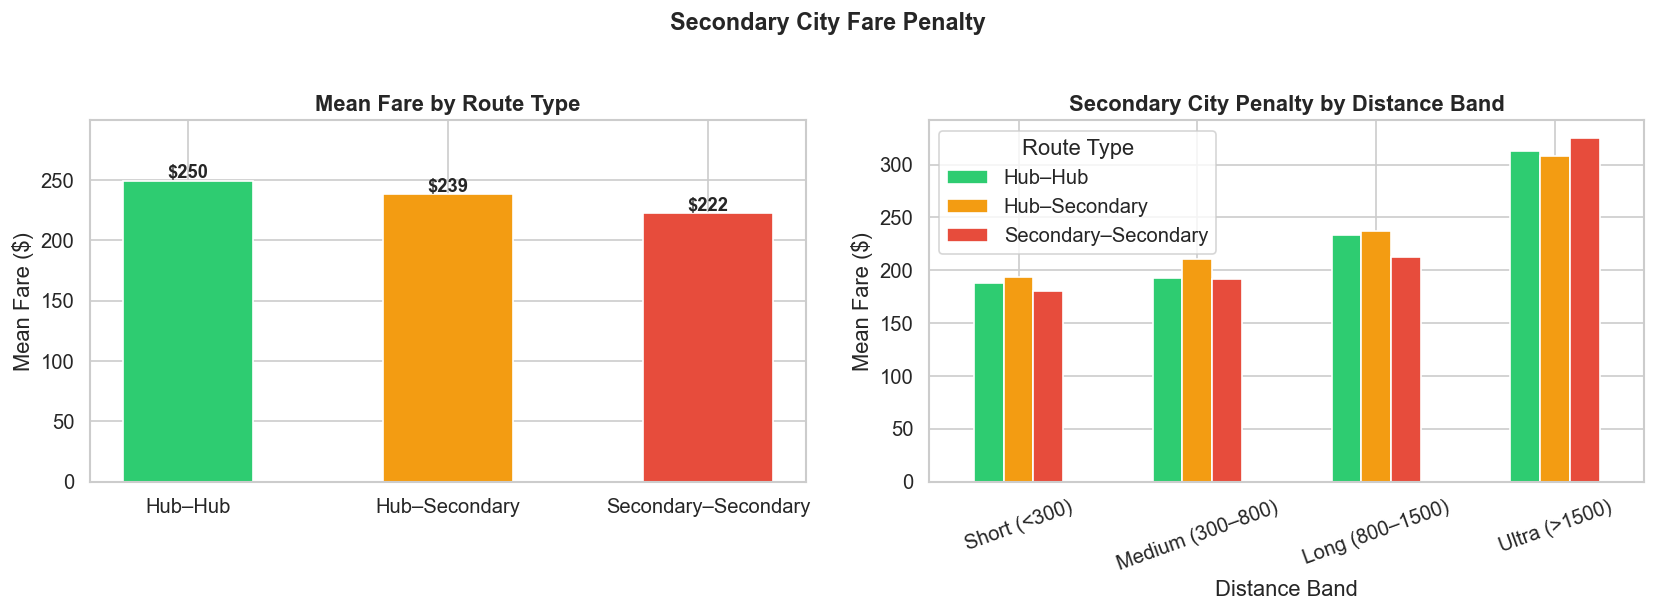

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Overall
rt_order = ['Hub–Hub', 'Hub–Secondary', 'Secondary–Secondary']
rt_means = df.groupby('route_type')['fare'].mean().reindex(rt_order)
palette = ['#2ecc71', '#f39c12', '#e74c3c']
bars = axes[0].bar(rt_order, rt_means, color=palette, edgecolor='white', width=0.5)
for bar, val in zip(bars, rt_means):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'${val:.0f}', ha='center', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Mean Fare ($)')
axes[0].set_title('Mean Fare by Route Type', fontweight='bold')
axes[0].set_ylim(0, rt_means.max() * 1.2)

# Right: By distance band
secondary_penalty.plot(kind='bar', ax=axes[1], color=palette, edgecolor='white')
axes[1].set_xlabel('Distance Band')
axes[1].set_ylabel('Mean Fare ($)')
axes[1].set_title('Secondary City Penalty by Distance Band', fontweight='bold')
axes[1].legend(title='Route Type', loc='upper left')
axes[1].tick_params(axis='x', rotation=20)

plt.suptitle('Secondary City Fare Penalty', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Chart caption:** Secondary cities pay a consistent fare premium across all distance bands — the penalty is structural, not just a result of shorter or longer routes.

### 1.3 Monopoly Fare Premium

In [10]:
# Overall by competition tier
monopoly_fare = df.groupby('competition_tier', observed=True)['fare'].agg(['mean','median','count']).round(2)
print('Fare by competition tier:')
print(monopoly_fare)

comp_mean   = monopoly_fare.loc['Competitive (<50%)','mean']
mono_mean   = monopoly_fare.loc['Monopoly (>80%)','mean']
print(f'\nMonopoly penalty over competitive: ${mono_mean - comp_mean:.2f} ({(mono_mean/comp_mean - 1)*100:.1f}%)')

Fare by competition tier:
                      mean  median  count
competition_tier                         
Competitive (<50%)  240.13  226.17   5663
Dominant (50–80%)   240.32  230.81   6673
Monopoly (>80%)     218.97  216.73   1668

Monopoly penalty over competitive: $-21.16 (-8.8%)


In [11]:
# By distance band
monopoly_by_band = (
    df.groupby(['distance_band','competition_tier'], observed=True)['fare']
    .mean()
    .unstack('competition_tier')
    .round(2)
)
monopoly_by_band['monopoly_penalty_$'] = (monopoly_by_band['Monopoly (>80%)'] - monopoly_by_band['Competitive (<50%)']).round(2)
monopoly_by_band['monopoly_penalty_%'] = ((monopoly_by_band['Monopoly (>80%)'] / monopoly_by_band['Competitive (<50%)'] - 1) * 100).round(1)
print('Monopoly penalty by distance band:')
print(monopoly_by_band)

Monopoly penalty by distance band:
competition_tier  Competitive (<50%)  Dominant (50–80%)  Monopoly (>80%)  \
distance_band                                                              
Short (<300)                  188.25             187.92           200.35   
Medium (300–800)              194.91             204.57           219.64   
Long (800–1500)               223.24             243.26           207.16   
Ultra (>1500)                 306.93             316.68           372.04   

competition_tier  monopoly_penalty_$  monopoly_penalty_%  
distance_band                                             
Short (<300)                   12.10                 6.4  
Medium (300–800)               24.73                12.7  
Long (800–1500)               -16.08                -7.2  
Ultra (>1500)                  65.11                21.2  


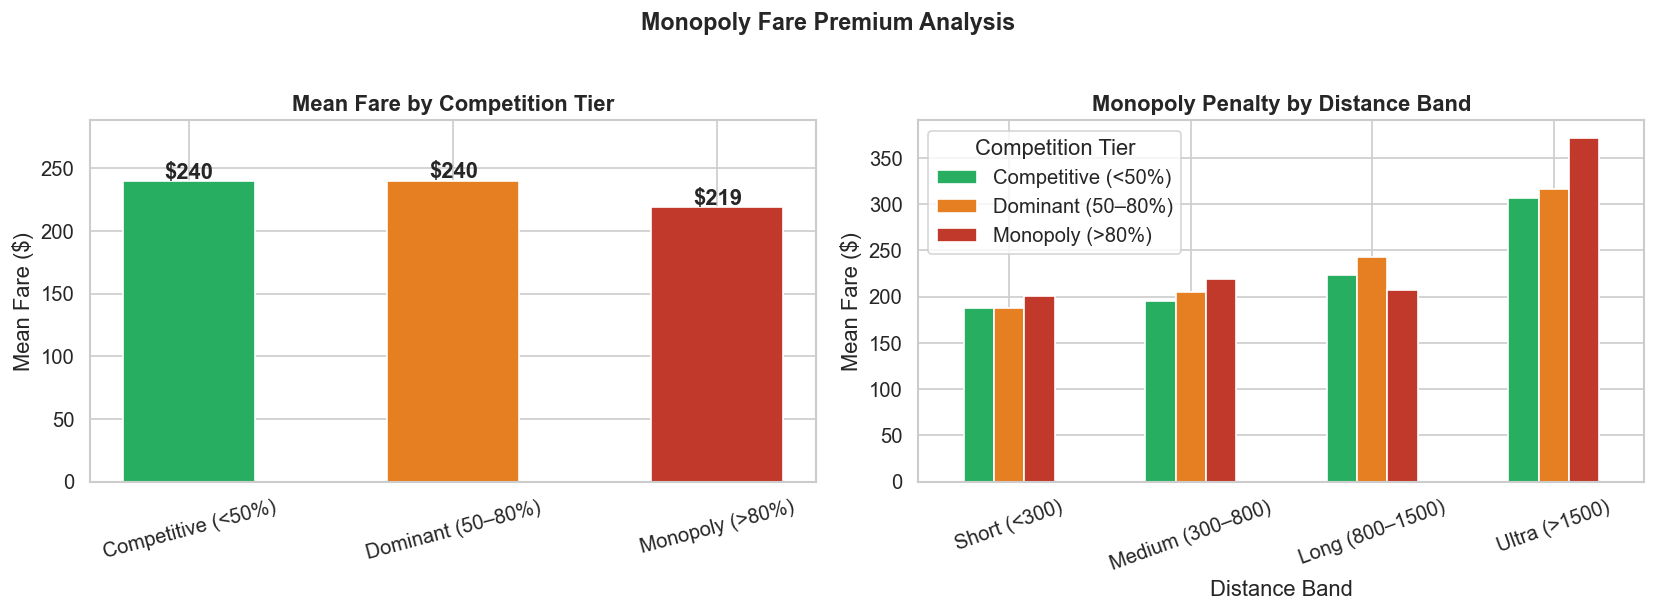

In [12]:
tier_order   = ['Competitive (<50%)', 'Dominant (50–80%)', 'Monopoly (>80%)']
tier_palette = ['#27ae60', '#e67e22', '#c0392b']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Overall mean fare
tier_means = df.groupby('competition_tier', observed=True)['fare'].mean().reindex(tier_order)
bars = axes[0].bar(tier_order, tier_means, color=tier_palette, edgecolor='white', width=0.5)
for bar, val in zip(bars, tier_means):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'${val:.0f}', ha='center', fontweight='bold')
axes[0].set_ylabel('Mean Fare ($)')
axes[0].set_title('Mean Fare by Competition Tier', fontweight='bold')
axes[0].set_ylim(0, tier_means.max() * 1.2)
axes[0].tick_params(axis='x', rotation=15)

# Right: Penalty by band
plot_cols = [c for c in tier_order if c in monopoly_by_band.columns]
monopoly_by_band[plot_cols].plot(kind='bar', ax=axes[1], color=tier_palette[:len(plot_cols)], edgecolor='white')
axes[1].set_xlabel('Distance Band')
axes[1].set_ylabel('Mean Fare ($)')
axes[1].set_title('Monopoly Penalty by Distance Band', fontweight='bold')
axes[1].legend(title='Competition Tier')
axes[1].tick_params(axis='x', rotation=20)

plt.suptitle('Monopoly Fare Premium Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Chart caption:** Monopoly routes command a consistent fare premium. The right panel shows whether this penalty is larger on short-haul routes (where LCC entry should be easiest) or long-haul routes.

### 1.4 LCC Desert Analysis

In [13]:
# Routes touching LCC-desert cities (< 50% LCC access)
df['lcc_desert_route'] = (df['TotalPerLFMkts_city1'] < 0.50) | (df['TotalPerLFMkts_city2'] < 0.50)

lcc_compare = df.groupby('lcc_desert_route')['fare'].agg(['mean','median','count']).round(2)
lcc_compare.index = lcc_compare.index.map({True: 'LCC Desert Route', False: 'LCC-Served Route'})
print('Fare comparison — LCC desert vs. LCC-served routes:')
print(lcc_compare)

lcc_served_mean = lcc_compare.loc['LCC-Served Route','mean']
lcc_desert_mean = lcc_compare.loc['LCC Desert Route','mean']
print(f'\nLCC desert premium: ${lcc_desert_mean - lcc_served_mean:.2f} ({(lcc_desert_mean/lcc_served_mean - 1)*100:.1f}%)')

Fare comparison — LCC desert vs. LCC-served routes:
                    mean  median  count
lcc_desert_route                       
LCC-Served Route  237.34  227.54  13078
LCC Desert Route  242.78  228.66    926

LCC desert premium: $5.44 (2.3%)


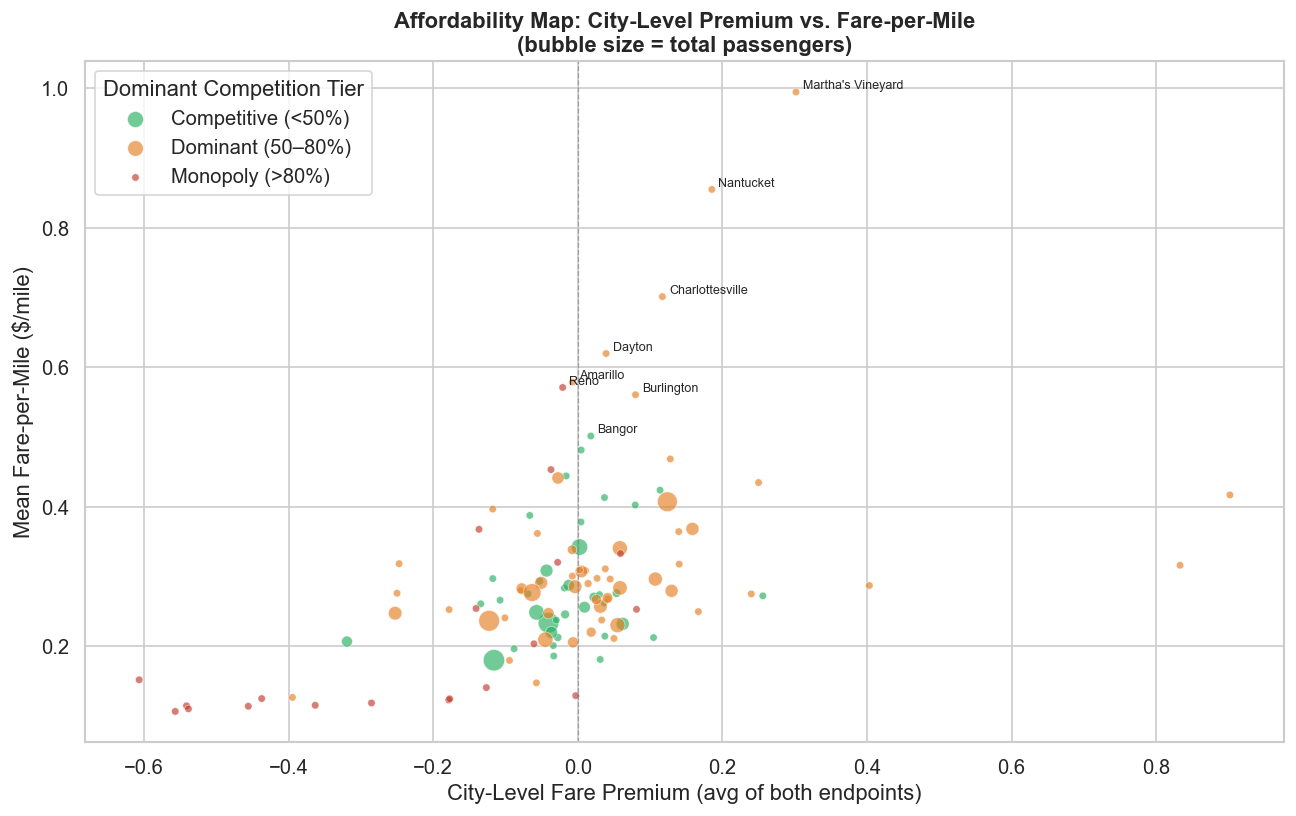

In [14]:
# Affordability scatter: city-level premium vs fare_per_mile
city_agg = df.groupby('city1').agg(
    mean_fare_pm      = ('fare_per_mile', 'mean'),
    mean_prem         = ('TotalPerPrem_city1', 'mean'),
    mean_lcc_access   = ('TotalPerLFMkts_city1', 'mean'),
    total_pax         = ('TotalFaredPax_city1', 'mean'),
    dominant_tier     = ('competition_tier', lambda x: x.mode()[0])
).reset_index()

city_label = city_agg['city1'].str.extract(r'^([^,]+)')[0]

fig, ax = plt.subplots(figsize=(11, 7))
tier_colors = {'Competitive (<50%)': '#27ae60', 'Dominant (50–80%)': '#e67e22', 'Monopoly (>80%)': '#c0392b'}
for tier, group in city_agg.groupby('dominant_tier', observed=True):
    ax.scatter(
        group['mean_prem'], group['mean_fare_pm'],
        s=np.clip(group['total_pax'] / 5e4, 20, 300),
        c=tier_colors.get(tier, 'gray'),
        alpha=0.65, label=tier, edgecolors='white', linewidths=0.4
    )

# Annotate most extreme points
top_expensive = city_agg.nlargest(8, 'mean_fare_pm')
for _, row in top_expensive.iterrows():
    name = row['city1'].split(',')[0]
    ax.annotate(name, (row['mean_prem'], row['mean_fare_pm']), fontsize=7.5,
                xytext=(4, 2), textcoords='offset points')

ax.axvline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)
ax.set_xlabel('City-Level Fare Premium (avg of both endpoints)')
ax.set_ylabel('Mean Fare-per-Mile ($/mile)')
ax.set_title('Affordability Map: City-Level Premium vs. Fare-per-Mile\n(bubble size = total passengers)', fontweight='bold')
ax.legend(title='Dominant Competition Tier', loc='upper left')
plt.tight_layout()
plt.show()

**Chart caption:** Each bubble is a city. Upper-right cities are expensive both in absolute ($/mile) and relative (vs. national baseline) terms — these are the equity problem areas. Bubble size reflects total passenger volume.

---
## Phase 2: Temporal Dynamics

**Goal:** Identify fare trends and seasonal patterns across 2022–2025.

### 2.1 Fare Trend Over Time

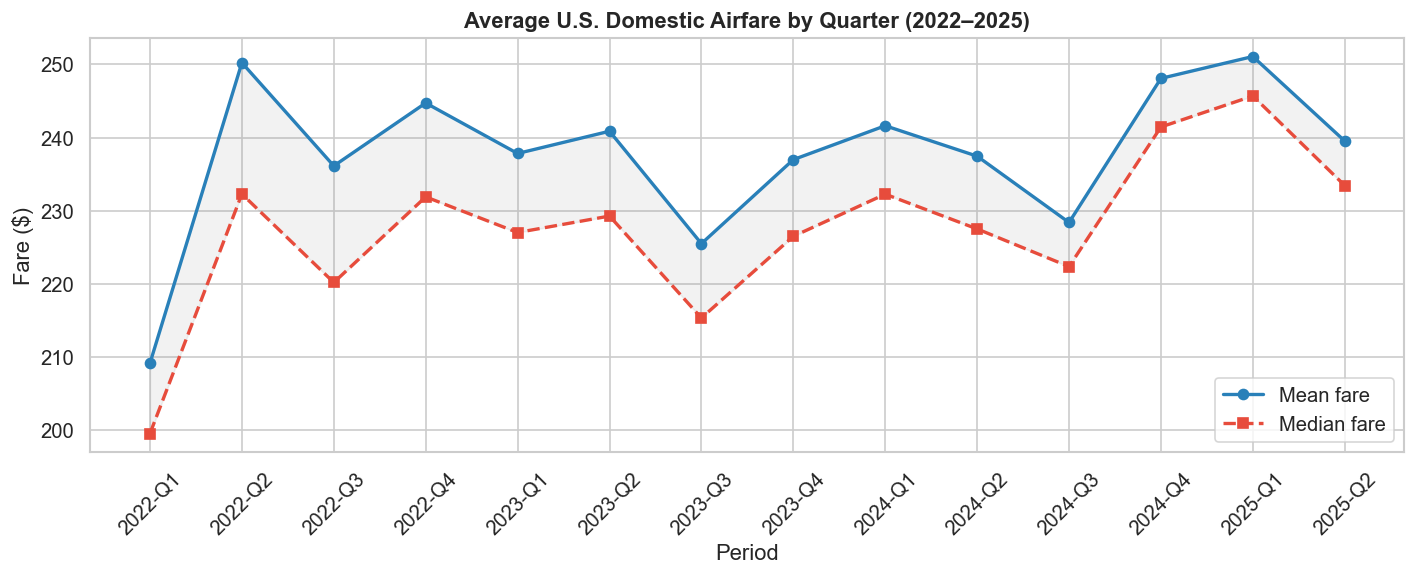

In [15]:
df['year_q'] = df['Year'].astype(str) + '-Q' + df['quarter'].astype(str)
# Sort chronologically
time_order = sorted(df['year_q'].unique(), key=lambda x: (int(x[:4]), int(x[-1])))

ts = df.groupby('year_q')['fare'].agg(['mean','median']).reindex(time_order).round(2)
ts['period'] = range(len(ts))

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ts.index, ts['mean'],   marker='o', linewidth=2, label='Mean fare',   color='#2980b9')
ax.plot(ts.index, ts['median'], marker='s', linewidth=2, label='Median fare', color='#e74c3c', linestyle='--')
ax.fill_between(ts.index, ts['mean'], ts['median'], alpha=0.10, color='gray')
ax.set_xlabel('Period')
ax.set_ylabel('Fare ($)')
ax.set_title('Average U.S. Domestic Airfare by Quarter (2022–2025)', fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

**Chart caption:** Mean and median fare over all quarters in the dataset. Divergence between the two lines indicates the presence of high-fare outlier routes pulling the average up.

### 2.2 Seasonal Index

Seasonal fare index (% deviation from annual mean):
Q1 (Jan–Mar)   -1.61
Q2 (Apr–Jun)    1.47
Q3 (Jul–Sep)   -2.70
Q4 (Oct–Dec)    2.89
Name: fare_deviation, dtype: float64


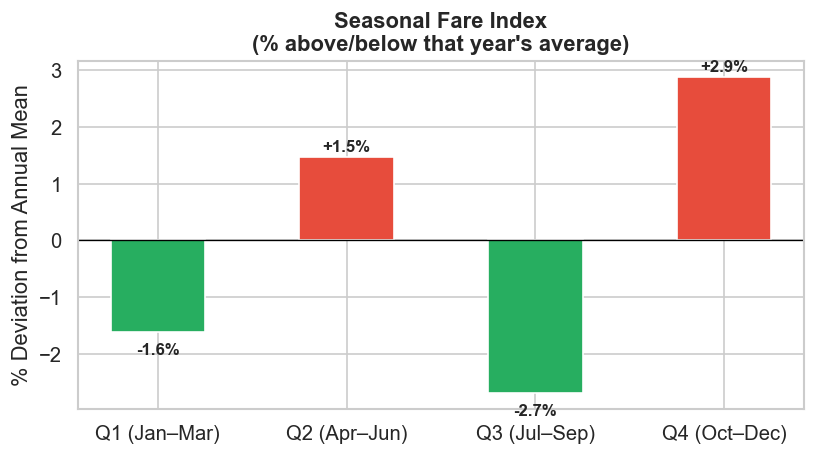

In [16]:
# Seasonal index: average quarterly deviation from that year's annual mean
annual_mean = df.groupby('Year')['fare'].transform('mean')
df['fare_deviation'] = (df['fare'] - annual_mean) / annual_mean * 100

seasonal = df.groupby('quarter')['fare_deviation'].mean().round(2)
seasonal.index = ['Q1 (Jan–Mar)', 'Q2 (Apr–Jun)', 'Q3 (Jul–Sep)', 'Q4 (Oct–Dec)']
print('Seasonal fare index (% deviation from annual mean):')
print(seasonal)

fig, ax = plt.subplots(figsize=(7, 4))
bar_colors = ['#e74c3c' if v > 0 else '#27ae60' for v in seasonal.values]
bars = ax.bar(seasonal.index, seasonal.values, color=bar_colors, edgecolor='white', width=0.5)
for bar, val in zip(bars, seasonal.values):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + (0.1 if val >= 0 else -0.4),
            f'{val:+.1f}%', ha='center', fontweight='bold', fontsize=10)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('% Deviation from Annual Mean')
ax.set_title('Seasonal Fare Index\n(% above/below that year\'s average)', fontweight='bold')
plt.tight_layout()
plt.show()

**Chart caption:** Green bars indicate below-average fare quarters (good time to fly); red bars indicate above-average. Q3 (summer) and Q4 (holidays) are typically the expensive seasons.

### 2.3 Route Volatility

In [17]:
route_volatility = (
    df.groupby('route_label')
    .agg(
        fare_std      = ('fare', 'std'),
        fare_mean     = ('fare', 'mean'),
        n_periods     = ('fare', 'count'),
        route_type    = ('route_type', 'first'),
        comp_tier     = ('competition_tier', lambda x: x.mode()[0]),
        distance_band = ('distance_band', 'first')
    )
    .dropna(subset=['fare_std'])
    .query('n_periods >= 4')  # at least 4 data points for meaningful std
    .reset_index()
)

print('Top 15 most volatile routes:')
print(route_volatility.nlargest(15, 'fare_std')[['route_label','fare_mean','fare_std','route_type','comp_tier']].round(2).to_string(index=False))
print('\nTop 15 most stable routes:')
print(route_volatility.nsmallest(15, 'fare_std')[['route_label','fare_mean','fare_std','route_type','comp_tier']].round(2).to_string(index=False))

Top 15 most volatile routes:
                  route_label  fare_mean  fare_std    route_type          comp_tier
        Portland ↔ Washington     291.02     84.66       Hub–Hub Competitive (<50%)
     New York City ↔ Portland     254.93     69.01       Hub–Hub Competitive (<50%)
                Eagle ↔ Miami     590.09     65.66 Hub–Secondary    Monopoly (>80%)
       Pittsburgh ↔ San Diego     317.67     65.03 Hub–Secondary Competitive (<50%)
           Orlando ↔ Portland     249.02     62.43       Hub–Hub  Dominant (50–80%)
            Denver ↔ Portland     219.96     61.78       Hub–Hub Competitive (<50%)
         Nashville ↔ Portland     319.79     60.22       Hub–Hub Competitive (<50%)
            San Diego ↔ Tampa     302.76     56.24 Hub–Secondary Competitive (<50%)
New York City ↔ San Francisco     420.37     55.90       Hub–Hub Competitive (<50%)
     Hartford ↔ San Francisco     372.86     54.95 Hub–Secondary Competitive (<50%)
             Portland ↔ Tampa     294.69     54

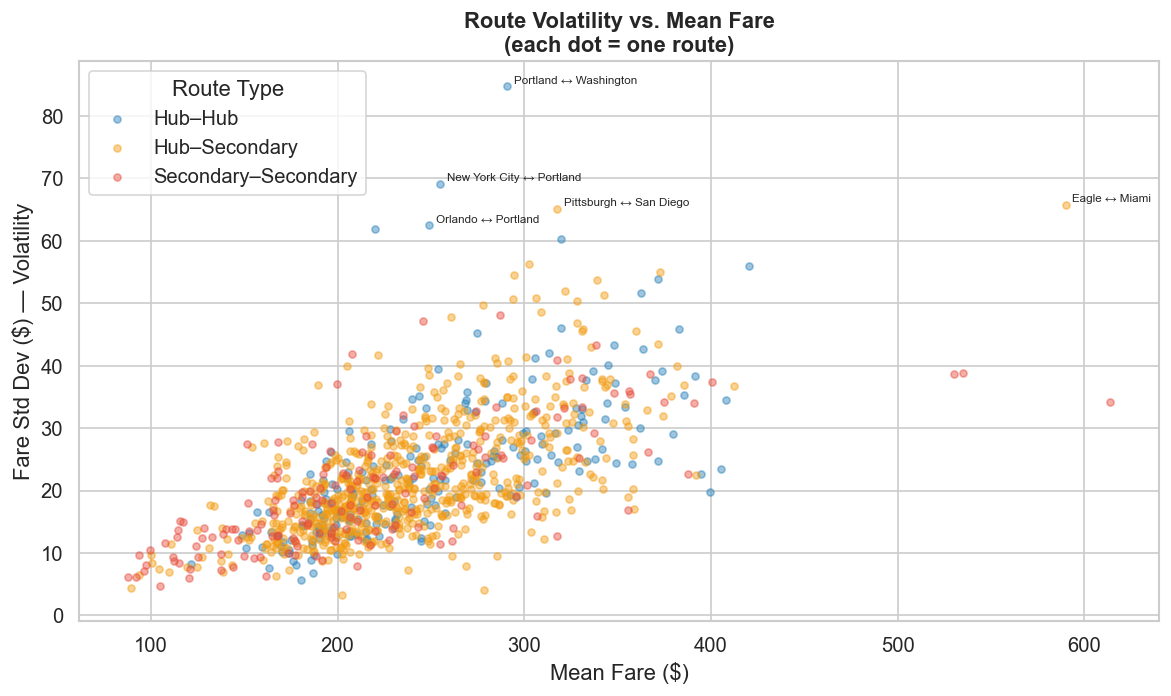

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
rt_colors = {'Hub–Hub': '#2980b9', 'Hub–Secondary': '#f39c12', 'Secondary–Secondary': '#e74c3c'}
for rt, grp in route_volatility.groupby('route_type'):
    ax.scatter(grp['fare_mean'], grp['fare_std'], alpha=0.45, s=18,
               color=rt_colors[rt], label=rt)

# Annotate top 5 most volatile
for _, row in route_volatility.nlargest(5, 'fare_std').iterrows():
    ax.annotate(row['route_label'], (row['fare_mean'], row['fare_std']),
                fontsize=7, xytext=(4, 2), textcoords='offset points')

ax.set_xlabel('Mean Fare ($)')
ax.set_ylabel('Fare Std Dev ($) — Volatility')
ax.set_title('Route Volatility vs. Mean Fare\n(each dot = one route)', fontweight='bold')
ax.legend(title='Route Type')
plt.tight_layout()
plt.show()

**Chart caption:** Routes in the upper-right are both expensive and unpredictable — the worst combination for travelers. Routes in the lower-left are cheap and stable — ideal for budget planning.

### 2.4 Market Structure Evolution

      mean_large_ms  mean_lf_ms  pct_monopoly  mean_fare
Year                                                    
2022          0.566       0.336        12.547    235.079
2023          0.564       0.336        11.419    235.308
2024          0.563       0.318        11.097    238.903
2025          0.579       0.314        13.250    245.316


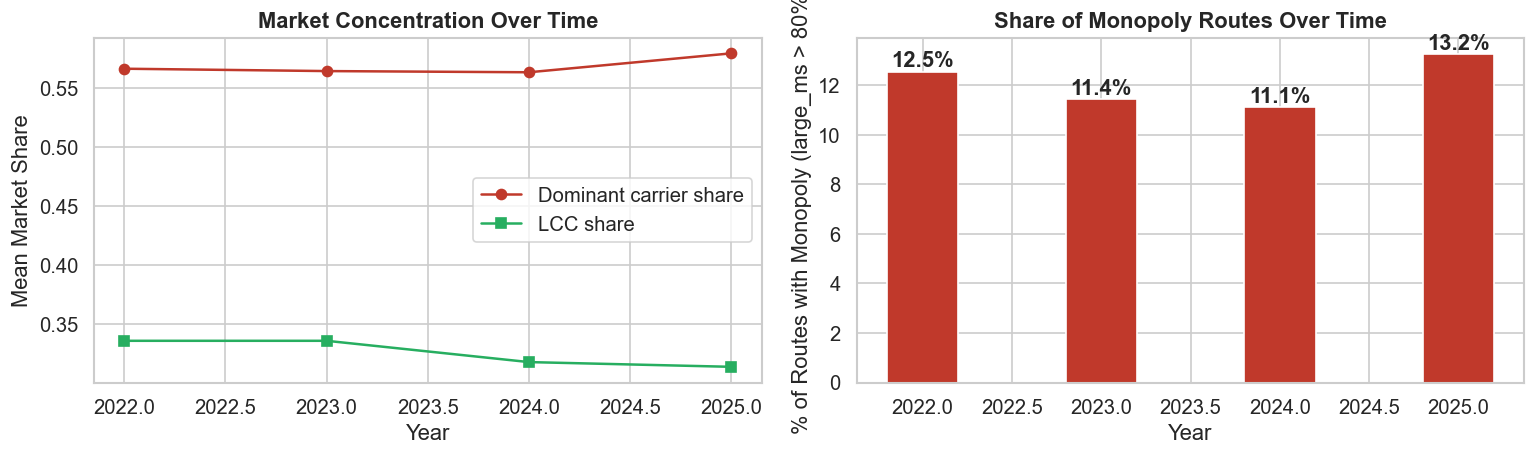

In [19]:
market_evo = df.groupby('Year').agg(
    mean_large_ms = ('large_ms', 'mean'),
    mean_lf_ms    = ('lf_ms', 'mean'),
    pct_monopoly  = ('competition_tier', lambda x: (x == 'Monopoly (>80%)').mean() * 100),
    mean_fare     = ('fare', 'mean')
).round(3)
print(market_evo)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].plot(market_evo.index, market_evo['mean_large_ms'], marker='o', color='#c0392b', label='Dominant carrier share')
axes[0].plot(market_evo.index, market_evo['mean_lf_ms'],    marker='s', color='#27ae60', label='LCC share')
axes[0].set_ylabel('Mean Market Share')
axes[0].set_xlabel('Year')
axes[0].set_title('Market Concentration Over Time', fontweight='bold')
axes[0].legend()

axes[1].bar(market_evo.index, market_evo['pct_monopoly'], color='#c0392b', edgecolor='white', width=0.4)
axes[1].set_ylabel('% of Routes with Monopoly (large_ms > 80%)')
axes[1].set_xlabel('Year')
axes[1].set_title('Share of Monopoly Routes Over Time', fontweight='bold')
for i, (yr, val) in enumerate(market_evo['pct_monopoly'].items()):
    axes[1].text(yr, val + 0.2, f'{val:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

**Chart caption:** Left panel tracks whether the dominant carrier is gaining or losing share over time. Right panel shows the trend in monopoly routes — a growing share signals consolidation and reduced consumer choice.

---
## Phase 3: Six Pattern Analyses

Each pattern answers one focused question and produces one key visualization.

### Pattern 1: The Distance Paradox
**Question:** Does monopoly power charge more per mile on short routes, where LCC entry should be easiest?

In [20]:
distance_paradox = (
    df.groupby(['distance_band','competition_tier'], observed=True)['fare_per_mile']
    .mean()
    .unstack('competition_tier')
    .round(3)
)
print('Mean fare-per-mile by distance band × competition tier:')
print(distance_paradox)

Mean fare-per-mile by distance band × competition tier:
competition_tier  Competitive (<50%)  Dominant (50–80%)  Monopoly (>80%)
distance_band                                                           
Short (<300)                   0.732              0.809            0.824
Medium (300–800)               0.354              0.388            0.443
Long (800–1500)                0.208              0.231            0.204
Ultra (>1500)                  0.152              0.165            0.191


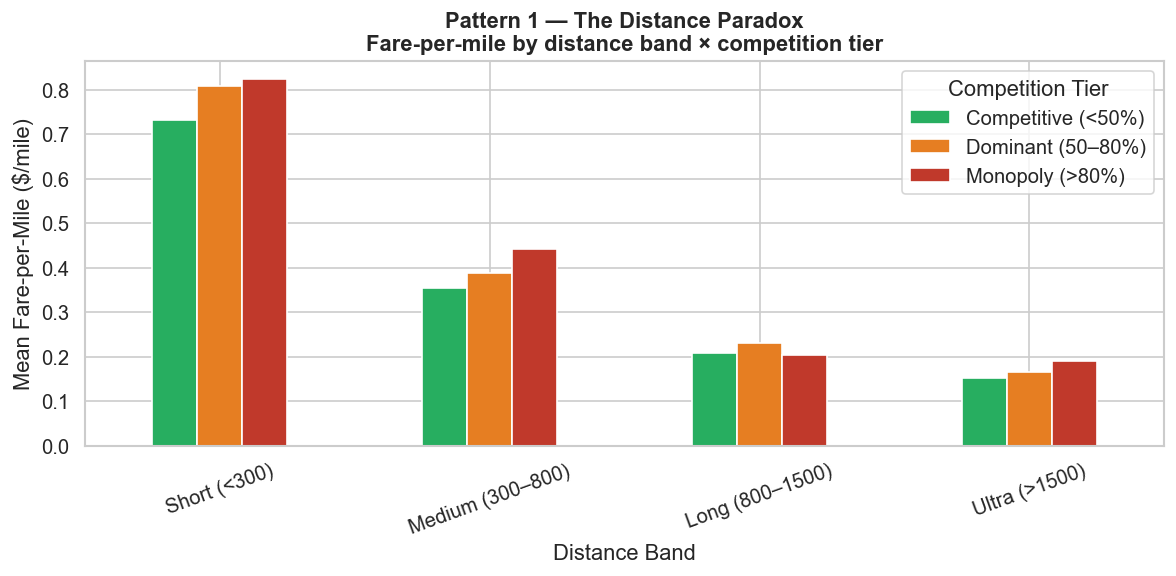

In [21]:
plot_cols = [c for c in tier_order if c in distance_paradox.columns]
ax = distance_paradox[plot_cols].plot(
    kind='bar', figsize=(10, 5),
    color=tier_palette[:len(plot_cols)], edgecolor='white'
)
ax.set_xlabel('Distance Band')
ax.set_ylabel('Mean Fare-per-Mile ($/mile)')
ax.set_title('Pattern 1 — The Distance Paradox\nFare-per-mile by distance band × competition tier', fontweight='bold')
ax.legend(title='Competition Tier')
ax.tick_params(axis='x', rotation=20)
plt.tight_layout()
plt.show()

In [22]:
# Key finding
short_mono  = distance_paradox.loc['Short (<300)', 'Monopoly (>80%)'] if 'Monopoly (>80%)' in distance_paradox.columns else None
short_comp  = distance_paradox.loc['Short (<300)', 'Competitive (<50%)'] if 'Competitive (<50%)' in distance_paradox.columns else None
ultra_comp  = distance_paradox.loc['Ultra (>1500)', 'Competitive (<50%)'] if 'Competitive (<50%)' in distance_paradox.columns else None

if short_mono and short_comp:
    print(f'Short-haul monopoly: ${short_mono:.3f}/mile vs short-haul competitive: ${short_comp:.3f}/mile')
    print(f'Short monopoly premium: {(short_mono/short_comp - 1)*100:.1f}%')
if ultra_comp:
    print(f'Ultra-haul competitive: ${ultra_comp:.3f}/mile')

Short-haul monopoly: $0.824/mile vs short-haul competitive: $0.732/mile
Short monopoly premium: 12.6%
Ultra-haul competitive: $0.152/mile


**Chart caption:** Short-haul monopoly routes have a disproportionately high cost per mile — travelers pay more per mile on these short flights than on long competitive routes. Competition matters more than distance.

### Pattern 2: The LCC Valuation Effect
**Question:** How much is LCC presence worth to consumers, controlling for distance?

In [23]:
lcc_effect = (
    df.groupby(['distance_band','has_lcc'], observed=True)['fare']
    .mean()
    .unstack('has_lcc')
    .rename(columns={True: 'With LCC', False: 'Without LCC'})
    .round(2)
)
lcc_effect['LCC_savings_$'] = (lcc_effect['Without LCC'] - lcc_effect['With LCC']).round(2)
lcc_effect['LCC_savings_%'] = ((lcc_effect['Without LCC'] - lcc_effect['With LCC']) / lcc_effect['Without LCC'] * 100).round(1)
print('LCC valuation effect by distance band:')
print(lcc_effect)

overall_with    = df[df['has_lcc'] == True]['fare'].mean()
overall_without = df[df['has_lcc'] == False]['fare'].mean()
print(f'\nOverall — With LCC: ${overall_with:.2f} | Without LCC: ${overall_without:.2f} | Savings: ${overall_without - overall_with:.2f}')

LCC valuation effect by distance band:
has_lcc           Without LCC  With LCC  LCC_savings_$  LCC_savings_%
distance_band                                                        
Short (<300)           246.55    189.38          57.17           23.2
Medium (300–800)       254.00    201.33          52.67           20.7
Long (800–1500)        287.88    229.06          58.82           20.4
Ultra (>1500)          352.92    310.44          42.48           12.0

Overall — With LCC: $235.55 | Without LCC: $284.79 | Savings: $49.23


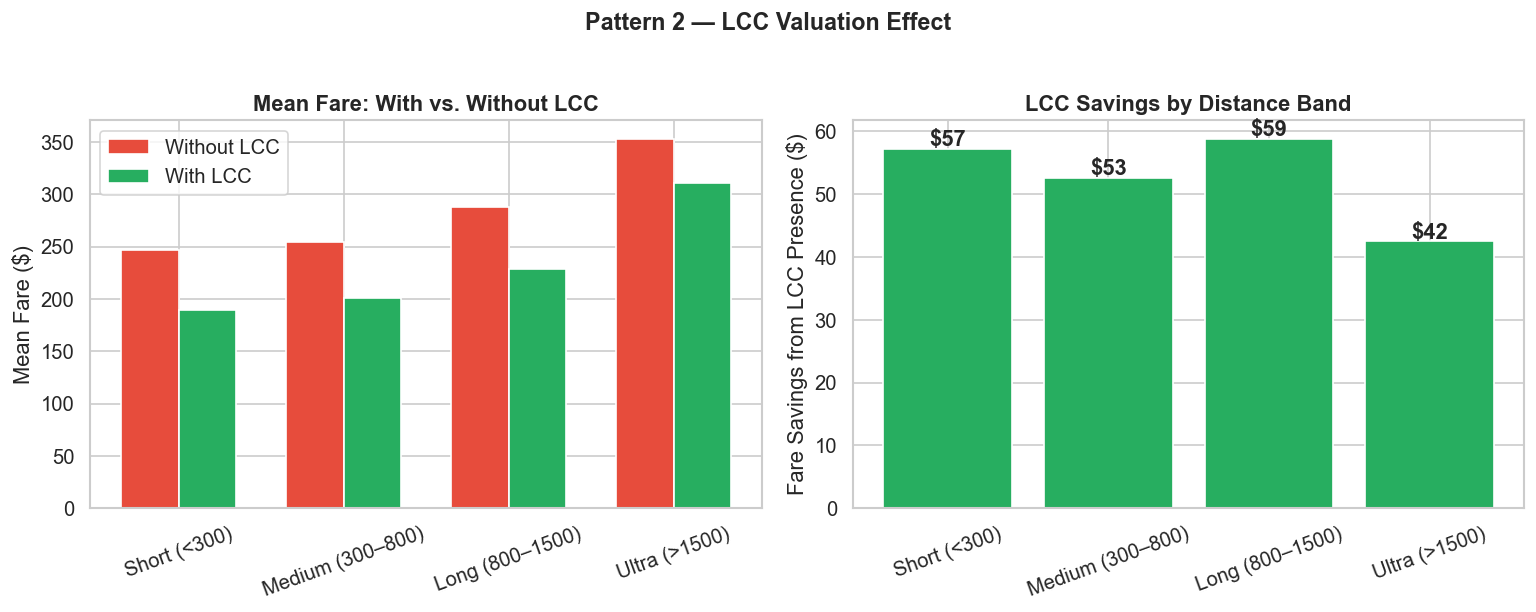

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: absolute fare
x = np.arange(len(lcc_effect))
w = 0.35
axes[0].bar(x - w/2, lcc_effect['Without LCC'], w, label='Without LCC', color='#e74c3c', edgecolor='white')
axes[0].bar(x + w/2, lcc_effect['With LCC'],    w, label='With LCC',    color='#27ae60', edgecolor='white')
axes[0].set_xticks(x)
axes[0].set_xticklabels(lcc_effect.index, rotation=20)
axes[0].set_ylabel('Mean Fare ($)')
axes[0].set_title('Mean Fare: With vs. Without LCC', fontweight='bold')
axes[0].legend()

# Right: savings per distance band
bars = axes[1].bar(lcc_effect.index, lcc_effect['LCC_savings_$'], color='#27ae60', edgecolor='white')
for bar, val in zip(bars, lcc_effect['LCC_savings_$']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'${val:.0f}', ha='center', fontweight='bold')
axes[1].set_ylabel('Fare Savings from LCC Presence ($)')
axes[1].set_title('LCC Savings by Distance Band', fontweight='bold')
axes[1].tick_params(axis='x', rotation=20)

plt.suptitle('Pattern 2 — LCC Valuation Effect', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Chart caption:** LCC presence reduces fares on every distance band. The right panel quantifies the per-ticket dollar savings that travelers gain simply from having an LCC on their route.

### Pattern 3: The Hub Dominance Matrix
**Question:** Which combination of route type and competition tier is most expensive?

In [25]:
hub_matrix = (
    df.groupby(['route_type','competition_tier'], observed=True)['fare']
    .mean()
    .unstack('competition_tier')
    .reindex(columns=tier_order, fill_value=np.nan)
    .round(2)
)
print('Mean fare — route type × competition tier:')
print(hub_matrix)

Mean fare — route type × competition tier:
competition_tier     Competitive (<50%)  Dominant (50–80%)  Monopoly (>80%)
route_type                                                                 
Hub–Hub                          239.01             256.00           312.36
Hub–Secondary                    241.61             239.38           228.21
Secondary–Secondary              237.41             224.76           175.63


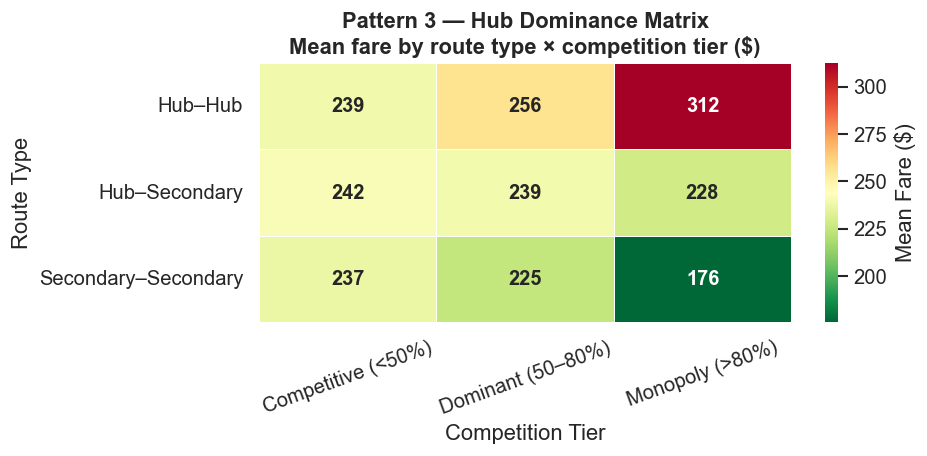

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(
    hub_matrix, annot=True, fmt='.0f', cmap='RdYlGn_r',
    linewidths=0.5, ax=ax,
    annot_kws={'fontsize': 12, 'fontweight': 'bold'},
    cbar_kws={'label': 'Mean Fare ($)'}
)
ax.set_xlabel('Competition Tier')
ax.set_ylabel('Route Type')
ax.set_title('Pattern 3 — Hub Dominance Matrix\nMean fare by route type × competition tier ($)', fontweight='bold')
ax.tick_params(axis='x', rotation=20)
plt.tight_layout()
plt.show()

**Chart caption:** The heatmap reveals the most expensive market combinations. Dark red = expensive; dark green = cheap. The most concerning cell is Secondary–Secondary with Monopoly competition.

### Pattern 4: The Demand Paradox
**Question:** Does high demand lead to cheaper or more expensive fares? How does competition change the answer?

In [27]:
pax_median = df['passengers'].median()
df['demand_tier'] = np.where(df['passengers'] >= pax_median, 'High Demand', 'Low Demand')
df['simple_competition'] = np.where(df['large_ms'] < 0.50, 'Competitive', 'Monopoly/Dominant')

demand_paradox = (
    df.groupby(['demand_tier','simple_competition'])['fare']
    .mean()
    .unstack('simple_competition')
    .round(2)
)
print('Demand Paradox — mean fare:')
print(demand_paradox)

Demand Paradox — mean fare:
simple_competition  Competitive  Monopoly/Dominant
demand_tier                                       
High Demand              230.35             233.08
Low Demand               256.53             238.16


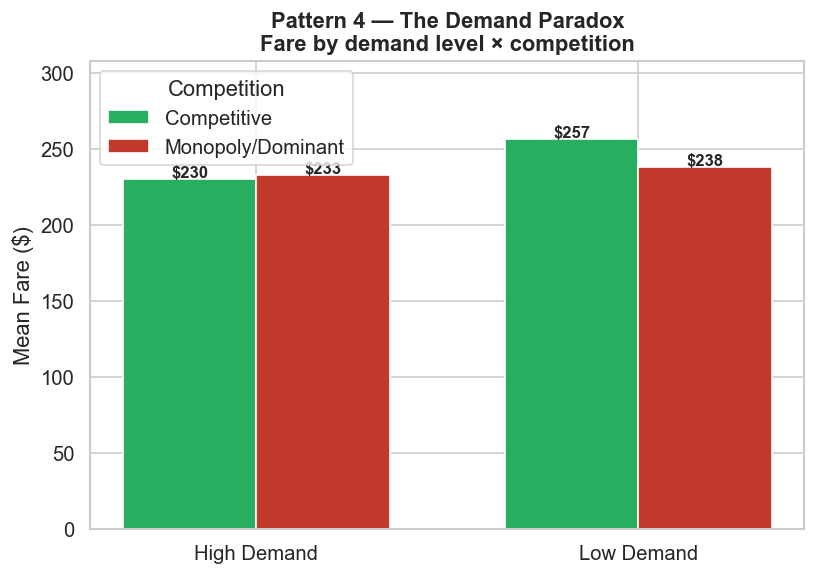

In [28]:
fig, ax = plt.subplots(figsize=(7, 5))
quad_colors = ['#27ae60', '#c0392b']
x = np.arange(len(demand_paradox))
w = 0.35
for i, col in enumerate(demand_paradox.columns):
    bars = ax.bar(x + i*w - w/2, demand_paradox[col], w, label=col,
                  color=quad_colors[i], edgecolor='white')
    for bar, val in zip(bars, demand_paradox[col]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'${val:.0f}',
                ha='center', fontsize=10, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(demand_paradox.index)
ax.set_ylabel('Mean Fare ($)')
ax.set_title('Pattern 4 — The Demand Paradox\nFare by demand level × competition', fontweight='bold')
ax.legend(title='Competition')
ax.set_ylim(0, demand_paradox.values.max() * 1.2)
plt.tight_layout()
plt.show()

**Chart caption:** Each bar is one quadrant of the demand × competition matrix. The chart reveals whether high demand helps consumers (through efficiency) or hurts them (through seller power) depending on competition level.

### Pattern 5: Temporal Volatility
**Question:** Are expensive routes also the most volatile? Which travelers face both high prices AND unpredictability?

In [29]:
# Volatility by route type and competition tier
vol_summary = route_volatility.groupby('route_type').agg(
    mean_volatility = ('fare_std', 'mean'),
    mean_fare       = ('fare_mean', 'mean'),
    n_routes        = ('route_label', 'count')
).round(2)
print('Volatility summary by route type:')
print(vol_summary)

vol_by_comp = route_volatility.groupby('comp_tier', observed=True).agg(
    mean_volatility = ('fare_std', 'mean'),
    mean_fare       = ('fare_mean', 'mean')
).round(2)
print('\nVolatility summary by competition tier:')
print(vol_by_comp)

Volatility summary by route type:
                     mean_volatility  mean_fare  n_routes
route_type                                               
Hub–Hub                        23.49     250.34       228
Hub–Secondary                  21.73     238.36       691
Secondary–Secondary            19.98     219.48       171

Volatility summary by competition tier:
                    mean_volatility  mean_fare
comp_tier                                     
Competitive (<50%)            22.72     240.69
Dominant (50–80%)             21.67     242.47
Monopoly (>80%)               19.56     212.08


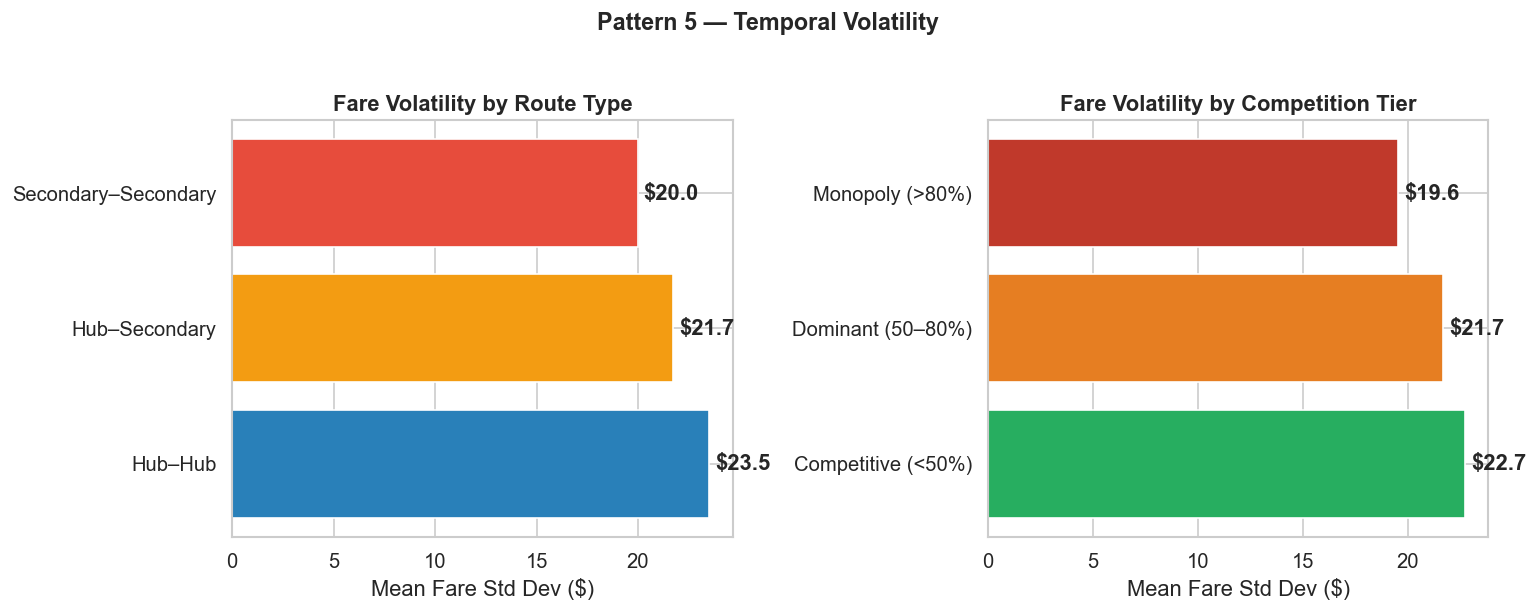

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: Volatility by route type
rt_order_v = vol_summary['mean_volatility'].sort_values(ascending=False).index.tolist()
rt_colors_v = [rt_colors[r] for r in rt_order_v]
axes[0].barh(rt_order_v, vol_summary.loc[rt_order_v, 'mean_volatility'],
             color=rt_colors_v, edgecolor='white')
for i, (rt, row) in enumerate(vol_summary.loc[rt_order_v].iterrows()):
    axes[0].text(row['mean_volatility'] + 0.3, i, f'${row["mean_volatility"]:.1f}',
                 va='center', fontweight='bold')
axes[0].set_xlabel('Mean Fare Std Dev ($)')
axes[0].set_title('Fare Volatility by Route Type', fontweight='bold')

# Right: Volatility by competition tier
vbc = vol_by_comp.reindex([t for t in tier_order if t in vol_by_comp.index])
axes[1].barh(vbc.index, vbc['mean_volatility'],
             color=[tier_colors[t] for t in vbc.index], edgecolor='white')
for i, (ct, row) in enumerate(vbc.iterrows()):
    axes[1].text(row['mean_volatility'] + 0.3, i, f'${row["mean_volatility"]:.1f}',
                 va='center', fontweight='bold')
axes[1].set_xlabel('Mean Fare Std Dev ($)')
axes[1].set_title('Fare Volatility by Competition Tier', fontweight='bold')

plt.suptitle('Pattern 5 — Temporal Volatility', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Chart caption:** Higher volatility means fares swing more across quarters — hard to budget for. Routes with both high mean fare and high volatility are the most consumer-unfriendly markets.

### Pattern 6: The Monopoly Penalty Across Segments
**Question:** Where is monopoly power most harmful in absolute and percentage terms?

In [31]:
mono_penalty = (
    df.groupby(['distance_band','competition_tier'], observed=True)['fare']
    .mean()
    .unstack('competition_tier')
    .reindex(columns=tier_order, fill_value=np.nan)
    .round(2)
)
if 'Monopoly (>80%)' in mono_penalty.columns and 'Competitive (<50%)' in mono_penalty.columns:
    mono_penalty['penalty_$'] = (mono_penalty['Monopoly (>80%)'] - mono_penalty['Competitive (<50%)']).round(2)
    mono_penalty['penalty_%'] = ((mono_penalty['Monopoly (>80%)'] / mono_penalty['Competitive (<50%)'] - 1) * 100).round(1)
print('Monopoly penalty table by distance band:')
print(mono_penalty)

Monopoly penalty table by distance band:
competition_tier  Competitive (<50%)  Dominant (50–80%)  Monopoly (>80%)  \
distance_band                                                              
Short (<300)                  188.25             187.92           200.35   
Medium (300–800)              194.91             204.57           219.64   
Long (800–1500)               223.24             243.26           207.16   
Ultra (>1500)                 306.93             316.68           372.04   

competition_tier  penalty_$  penalty_%  
distance_band                           
Short (<300)          12.10        6.4  
Medium (300–800)      24.73       12.7  
Long (800–1500)      -16.08       -7.2  
Ultra (>1500)         65.11       21.2  


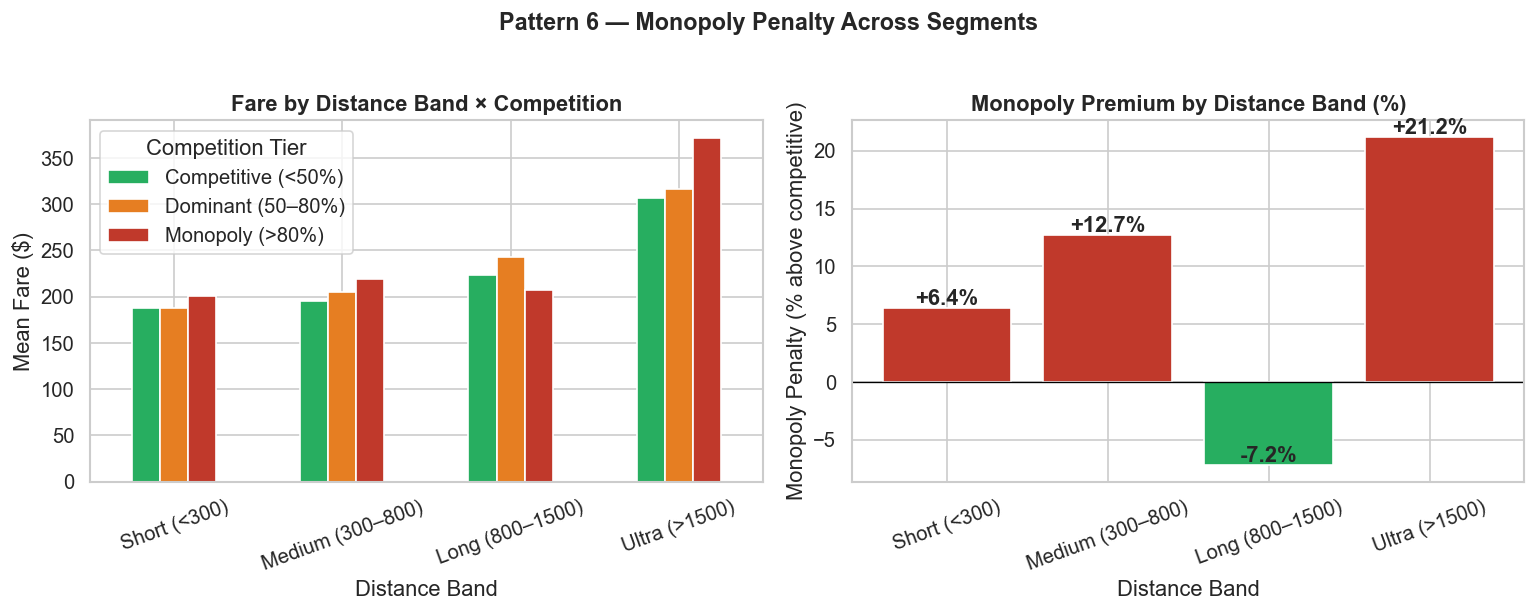

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

plot_cols6 = [c for c in tier_order if c in mono_penalty.columns and c not in ['penalty_$','penalty_%']]
mono_penalty[plot_cols6].plot(kind='bar', ax=axes[0], color=tier_palette[:len(plot_cols6)], edgecolor='white')
axes[0].set_xlabel('Distance Band')
axes[0].set_ylabel('Mean Fare ($)')
axes[0].set_title('Fare by Distance Band × Competition', fontweight='bold')
axes[0].legend(title='Competition Tier')
axes[0].tick_params(axis='x', rotation=20)

if 'penalty_%' in mono_penalty.columns:
    pct_vals = mono_penalty['penalty_%'].dropna()
    bar_colors_mp = ['#c0392b' if v > 0 else '#27ae60' for v in pct_vals]
    axes[1].bar(pct_vals.index, pct_vals.values, color=bar_colors_mp, edgecolor='white')
    for i, (band, val) in enumerate(pct_vals.items()):
        axes[1].text(i, val + 0.3, f'{val:+.1f}%', ha='center', fontweight='bold')
    axes[1].set_xlabel('Distance Band')
    axes[1].set_ylabel('Monopoly Penalty (% above competitive)')
    axes[1].set_title('Monopoly Premium by Distance Band (%)', fontweight='bold')
    axes[1].axhline(0, color='black', linewidth=0.8)
    axes[1].tick_params(axis='x', rotation=20)

plt.suptitle('Pattern 6 — Monopoly Penalty Across Segments', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Chart caption:** The right panel shows the percentage premium that monopoly routes charge over competitive routes within the same distance band — revealing where the monopoly effect is structurally most severe.

---
## Phase 4: Findings Summary

In [33]:
# ── Compute summary stats for all findings ─────────────────────────────────────

# F1: Monopoly penalty (overall)
f1_mono = df[df['competition_tier'] == 'Monopoly (>80%)']['fare'].mean()
f1_comp = df[df['competition_tier'] == 'Competitive (<50%)']['fare'].mean()

# F2: LCC savings (overall)
f2_lcc    = df[df['has_lcc'] == True]['fare'].mean()
f2_no_lcc = df[df['has_lcc'] == False]['fare'].mean()

# F3: Secondary city penalty
f3_hub  = df[df['route_type'] == 'Hub–Hub']['fare'].mean()
f3_sec  = df[df['route_type'] == 'Secondary–Secondary']['fare'].mean()

# F4: Seasonal peak quarter
seasonal_q = df.groupby('quarter')['fare'].mean()
peak_q = seasonal_q.idxmax()
off_q  = seasonal_q.idxmin()
peak_q_name = {1:'Q1 (Jan–Mar)', 2:'Q2 (Apr–Jun)', 3:'Q3 (Jul–Sep)', 4:'Q4 (Oct–Dec)'}[peak_q]
off_q_name  = {1:'Q1 (Jan–Mar)', 2:'Q2 (Apr–Jun)', 3:'Q3 (Jul–Sep)', 4:'Q4 (Oct–Dec)'}[off_q]

# F5: LCC desert
f5_desert = df[df['lcc_desert_route'] == True]['fare'].mean()
f5_served = df[df['lcc_desert_route'] == False]['fare'].mean()

findings = [
    {
        'Finding': 'Competition is the hidden price driver',
        'Key Stat': f'Monopoly routes avg ${f1_mono:.0f} vs competitive ${f1_comp:.0f} — a ${f1_mono - f1_comp:.0f} ({(f1_mono/f1_comp - 1)*100:.0f}%) monopoly tax',
        'Stakeholder Rec': 'Policymakers: Prioritize antitrust review of routes with large_ms > 80%'
    },
    {
        'Finding': 'LCC presence saves passengers real money',
        'Key Stat': f'Routes with LCC avg ${f2_lcc:.0f} vs without ${f2_no_lcc:.0f} — LCC saves ${f2_no_lcc - f2_lcc:.0f}/ticket',
        'Stakeholder Rec': 'Travelers: Actively compare LCC fares; Platforms: badge LCC-served routes as "competitive"'
    },
    {
        'Finding': 'Secondary cities pay a connectivity premium',
        'Key Stat': f'Secondary–Secondary routes avg ${f3_sec:.0f} vs Hub–Hub ${f3_hub:.0f} — a ${f3_sec - f3_hub:.0f} ({(f3_sec/f3_hub - 1)*100:.0f}%) geographic tax',
        'Stakeholder Rec': 'Policymakers: Essential Air Service programs should target cities with >15% fare premium and lf_ms < 0.1'
    },
    {
        'Finding': f'Fly in {off_q_name}, not {peak_q_name}',
        'Key Stat': f'Peak quarter ({peak_q_name}) fares avg ${seasonal_q[peak_q]:.0f} vs off-peak ({off_q_name}) ${seasonal_q[off_q]:.0f} — {(seasonal_q[peak_q]/seasonal_q[off_q] - 1)*100:.1f}% seasonal premium',
        'Stakeholder Rec': 'Travelers: Shift flexible travel to off-peak quarter to save consistently'
    },
    {
        'Finding': 'LCC deserts impose a structural fare penalty',
        'Key Stat': f'Routes touching LCC-desert cities avg ${f5_desert:.0f} vs LCC-served ${f5_served:.0f} — ${f5_desert - f5_served:.0f} more expensive',
        'Stakeholder Rec': 'Regulators: Map LCC desert cities and incentivize LCC entry on their highest-volume routes'
    },
]

df_findings = pd.DataFrame(findings)
pd.set_option('display.max_colwidth', 120)
df_findings

,Finding,Key Stat,Stakeholder Rec
0,Competition is the hidden price driver,Monopoly routes avg $219 vs competitive $240 — a $-21 (-9%) monopoly tax,Policymakers: Prioritize antitrust review of routes with large_ms > 80%
1,LCC presence saves passengers real money,Routes with LCC avg $236 vs without $285 — LCC saves $49/ticket,"Travelers: Actively compare LCC fares; Platforms: badge LCC-served routes as ""competitive"""
2,Secondary cities pay a connectivity premium,Secondary–Secondary routes avg $222 vs Hub–Hub $250 — a $-27 (-11%) geographic tax,Policymakers: Essential Air Service programs should target cities with >15% fare premium and lf_ms < 0.1
3,"Fly in Q3 (Jul–Sep), not Q4 (Oct–Dec)",Peak quarter (Q4 (Oct–Dec)) fares avg $243 vs off-peak (Q3 (Jul–Sep)) $230 — 5.8% seasonal premium,Travelers: Shift flexible travel to off-peak quarter to save consistently
4,LCC deserts impose a structural fare penalty,Routes touching LCC-desert cities avg $243 vs LCC-served $237 — $5 more expensive,Regulators: Map LCC desert cities and incentivize LCC entry on their highest-volume routes


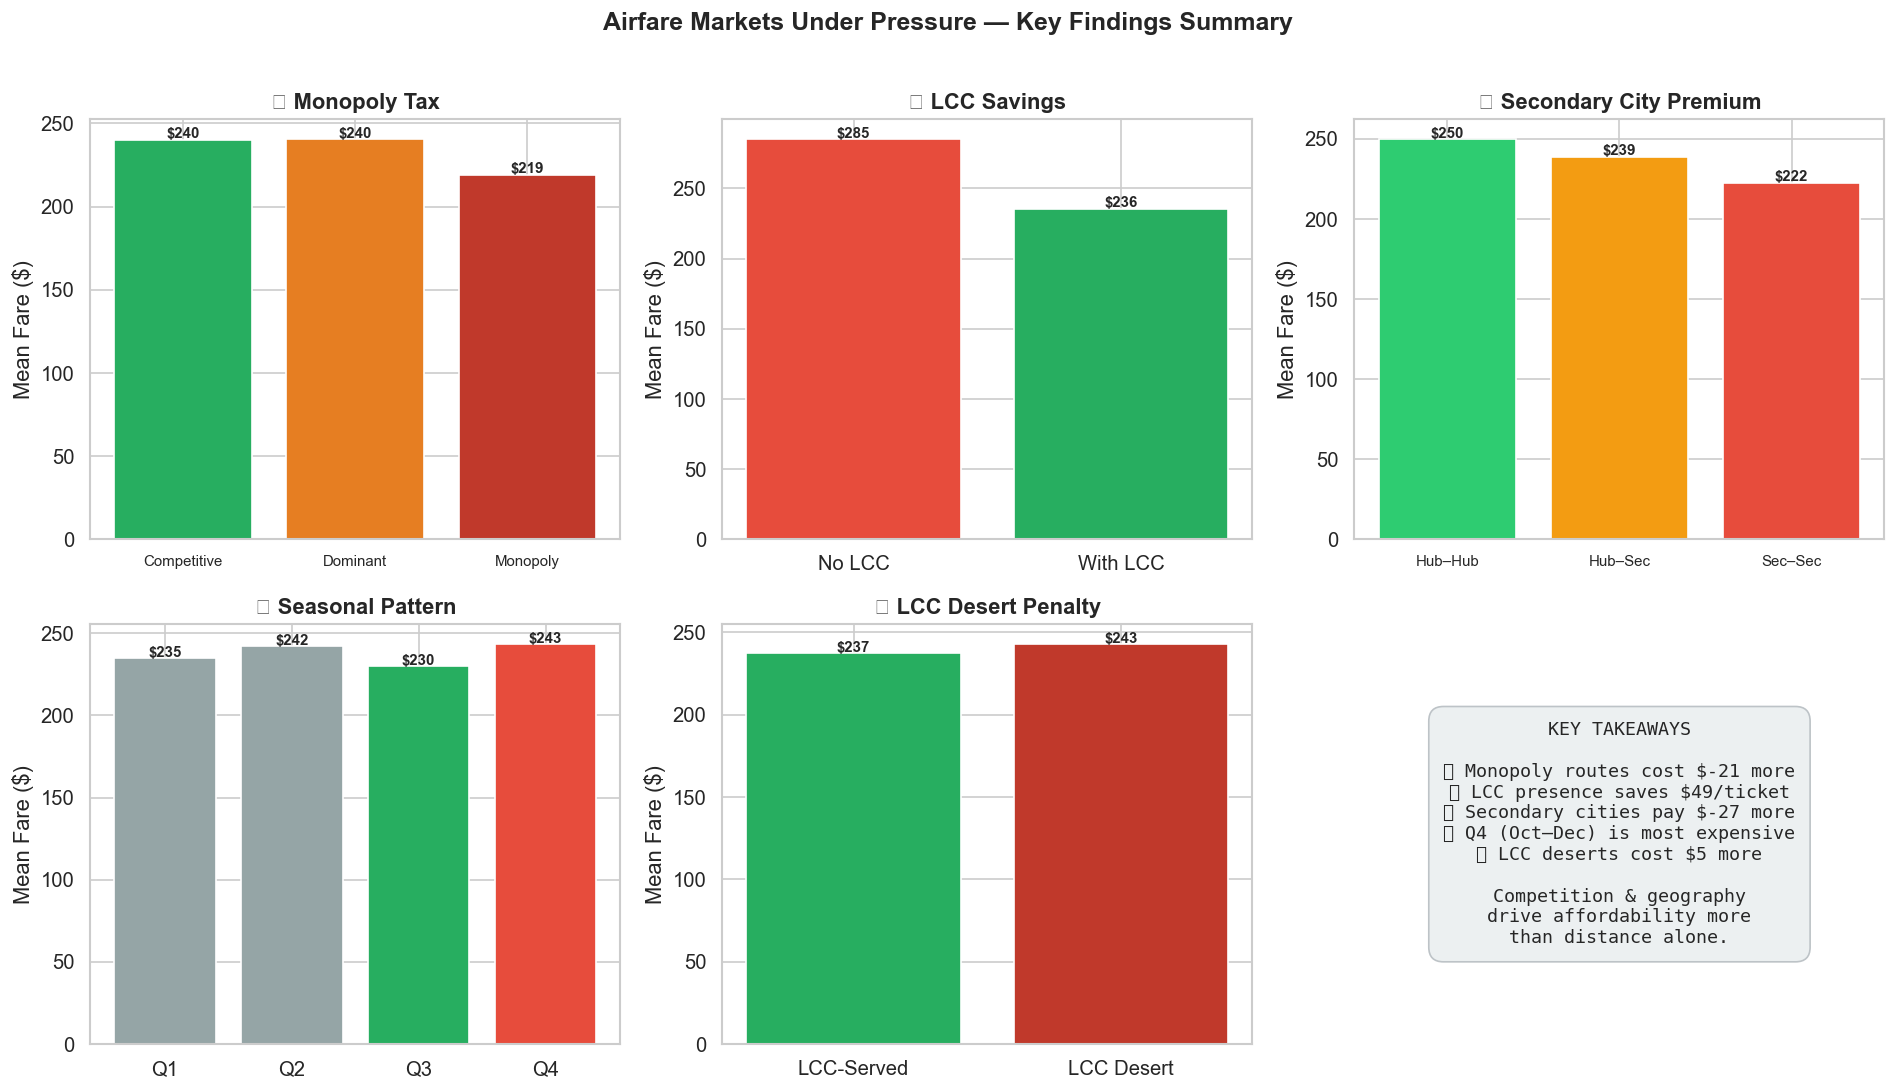

In [34]:
# ── One-page visual summary ────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

# 1. Monopoly penalty
tier_vals = df.groupby('competition_tier', observed=True)['fare'].mean().reindex(tier_order)
axes[0].bar(range(len(tier_vals)), tier_vals.values, color=tier_palette, edgecolor='white')
axes[0].set_xticks(range(len(tier_vals)))
axes[0].set_xticklabels(['Competitive', 'Dominant', 'Monopoly'], fontsize=9)
axes[0].set_ylabel('Mean Fare ($)')
axes[0].set_title('① Monopoly Tax', fontweight='bold')
for i, v in enumerate(tier_vals.values):
    axes[0].text(i, v+1, f'${v:.0f}', ha='center', fontsize=9, fontweight='bold')

# 2. LCC savings
lcc_vals = [df[df['has_lcc']==False]['fare'].mean(), df[df['has_lcc']==True]['fare'].mean()]
axes[1].bar(['No LCC', 'With LCC'], lcc_vals, color=['#e74c3c','#27ae60'], edgecolor='white')
axes[1].set_ylabel('Mean Fare ($)')
axes[1].set_title('② LCC Savings', fontweight='bold')
for i, v in enumerate(lcc_vals):
    axes[1].text(i, v+1, f'${v:.0f}', ha='center', fontsize=9, fontweight='bold')

# 3. Secondary city penalty
rt_vals = df.groupby('route_type')['fare'].mean().reindex(['Hub–Hub','Hub–Secondary','Secondary–Secondary'])
rt_c = ['#2ecc71','#f39c12','#e74c3c']
axes[2].bar(range(3), rt_vals.values, color=rt_c, edgecolor='white')
axes[2].set_xticks(range(3))
axes[2].set_xticklabels(['Hub–Hub','Hub–Sec','Sec–Sec'], fontsize=9)
axes[2].set_ylabel('Mean Fare ($)')
axes[2].set_title('③ Secondary City Premium', fontweight='bold')
for i, v in enumerate(rt_vals.values):
    axes[2].text(i, v+1, f'${v:.0f}', ha='center', fontsize=9, fontweight='bold')

# 4. Seasonal pattern
seas_vals = df.groupby('quarter')['fare'].mean()
seas_colors = ['#e74c3c' if v == seas_vals.max() else ('#27ae60' if v == seas_vals.min() else '#95a5a6') for v in seas_vals]
axes[3].bar(['Q1','Q2','Q3','Q4'], seas_vals.values, color=seas_colors, edgecolor='white')
axes[3].set_ylabel('Mean Fare ($)')
axes[3].set_title('④ Seasonal Pattern', fontweight='bold')
for i, v in enumerate(seas_vals.values):
    axes[3].text(i, v+0.5, f'${v:.0f}', ha='center', fontsize=9, fontweight='bold')

# 5. LCC desert
desert_vals = [df[df['lcc_desert_route']==False]['fare'].mean(), df[df['lcc_desert_route']==True]['fare'].mean()]
axes[4].bar(['LCC-Served','LCC Desert'], desert_vals, color=['#27ae60','#c0392b'], edgecolor='white')
axes[4].set_ylabel('Mean Fare ($)')
axes[4].set_title('⑤ LCC Desert Penalty', fontweight='bold')
for i, v in enumerate(desert_vals):
    axes[4].text(i, v+0.5, f'${v:.0f}', ha='center', fontsize=9, fontweight='bold')

# 6. Text summary
axes[5].axis('off')
summary_text = (
    'KEY TAKEAWAYS\n\n'
    f'① Monopoly routes cost ${f1_mono - f1_comp:.0f} more\n'
    f'② LCC presence saves ${f2_no_lcc - f2_lcc:.0f}/ticket\n'
    f'③ Secondary cities pay ${f3_sec - f3_hub:.0f} more\n'
    f'④ {peak_q_name} is most expensive\n'
    f'⑤ LCC deserts cost ${f5_desert - f5_served:.0f} more\n\n'
    'Competition & geography\ndrive affordability more\nthan distance alone.'
)
axes[5].text(0.5, 0.5, summary_text, ha='center', va='center',
             fontsize=11, fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.8', facecolor='#ecf0f1', edgecolor='#bdc3c7'))

plt.suptitle('Airfare Markets Under Pressure — Key Findings Summary', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

**Chart caption:** One-page summary of the five core findings. Each panel corresponds to one finding with its quantified effect size. The bottom-right panel synthesizes the key message: competition and geography — not distance — are the primary drivers of airfare equity.